In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
import pickle
import torch
import torch.nn as nn

from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from os.path import join
from scipy.stats import binom

import sys
sys.path.append(os.getcwd() + "/../")
from gatsbi.task_utils.cdsb_MNIST import Simulator, Generator, Prior
from gatsbi.networks import WrapGenMultipleSimulations
from torchmetrics.image import PeakSignalNoiseRatio
from torchmetrics.image import StructuralSimilarityIndexMeasure


2023-08-21 16:30:47.845256: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-21 16:30:47.847894: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-21 16:30:47.899291: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-21 16:30:47.900463: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-21 16:30:49.760074: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

# Download data from WANDB
And put them in dataframes

In [3]:
import pandas as pd
import wandb
api = wandb.Api()

def obtain_wandb_data(project):
    runs_list = []
    new_dict_list = []

    # Project is specified by <entity/project-name>
    runs = api.runs("bencekaszas/" + project)
    
    for run in runs:
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        summary_dict = run.summary._json_dict

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_dict = {k: v for k, v in run.config.items()
                        if not k.startswith('_')}

        # .name is the human-readable name of the run.
        new_dict = {"name": run.name, "ID": run.id, **config_dict, **summary_dict}
        new_dict_list.append(new_dict)           

    runs_list.append(pd.DataFrame(new_dict_list))

    return runs_list


runs_list = obtain_wandb_data("CDSB-MNIST-vaegan-COLAB")

In [4]:
runs_list = runs_list[0].sort_values("name")

In [5]:
runs_list.columns

Index(['name', 'ID', 'epochs', 'patch_size', 'patch_step', 'patched_sr',
       'sample_seed', 'gen_opt_args', 'scoring_rule', 'hold_out_perc',
       'log_dataloader', 'batch_size_perc', 'num_training_simulations',
       'num_simulations_generator', '_runtime', 'r2_val_std', 'rmse_val_std',
       'cal_err_val_std', 'cal_err_val_mean', 'early_stop_at_epoch', '_step',
       'global_step', 'r2_val_mean', 'sbc_lines', 'gen_grad', 'gen_loss',
       '_timestamp', 'train_time', 'rmse_val_mean', '_wandb'],
      dtype='object')

In [6]:
runs_list

,name,ID,epochs,patch_size,patch_step,patched_sr,sample_seed,gen_opt_args,scoring_rule,hold_out_perc,...,_step,global_step,r2_val_mean,sbc_lines,gen_grad,gen_loss,_timestamp,train_time,rmse_val_mean,_wandb
1,cdsb_MNIST_energy_score_10,ugvieqk2,5000,NaN,NaN,False,42,"[0.0002, [0.5, 0.99]]",energy_score,0.1,...,7,1000,0.083562,"{'height': 500, 'sha256': '5bdc7ab89bdd41de101...",NaN,3.388779,1.692552e+09,1148.292838,0.071733,{'runtime': 5096}
0,cdsb_MNIST_energy_score_10_patched_5_8,lsxg4l69,5000,8.0,5.0,True,42,"[0.0002, [0.5, 0.99]]",energy_score,0.1,...,11,1800,0.545087,"{'size': 159440, '_type': 'image-file', 'width...",NaN,3.362769,1.692566e+09,2185.478559,0.062445,{'runtime': 6646}


In [10]:
from copy import deepcopy
from tabulate import tabulate

def print_table(df, latex=False, file=None, tranpose=False):

    metrics = [['rmse_val_std', 'rmse_val_mean'], ['cal_err_val_std', 'cal_err_val_mean'],
                   ['r2_val_std', 'r2_val_mean'], ['_runtime'], ['global_step']]
    metric_names = [r"NRMSE $ \downarrow $", r"Cal. Err. $ \downarrow $", r"R$^2$ $ \uparrow $", "Runtime (sec)", "Early stopping epoch"]
    
    df_dict = df.to_dict("list")
    
    name_list = [""] + [name.replace("RedSea", "").replace("_", " ").replace("score", "") for name in df_dict["name"]]
    
    all_lists = []
    all_lists.append(name_list)

    for name, metric in zip(metric_names, metrics): 
        inner_list = [name]    

        if len(metric) == 2:
            inner_list += [f"{df_dict[metric[1]][i]:.2f} $\pm$ {df_dict[metric[0]][i]:.2f}" for i in range(len(df_dict[metric[0]]))]
        else:
            inner_list += [f"{df_dict[metric[0]][i]:.2f}" for i in range(len(df_dict[metric[0]]))]
                
        all_lists.append(deepcopy(inner_list))

    if tranpose: 
        all_lists = list(map(list, zip(*all_lists)))
    
    if file is None:
        if latex: 
            print(tabulate(all_lists, headers="firstrow", tablefmt="latex_raw"))
        else:
            print(tabulate(all_lists, headers="firstrow"))
    else:
        with open(file, 'w') as f:
            if latex: 
                f.write(tabulate(all_lists, headers="firstrow", tablefmt="latex_raw"))
            else:
                f.write(tabulate(all_lists, headers="firstrow"))

In [8]:
print_table(runs_list, file=f"plotting_code/tables/CDSB_mnist_all_metrics_n_gen={10}", latex=True, tranpose=True)

# Posterior samples

In [11]:
gen = Generator()
simulator = Simulator()

root_folder = "/home/bence/Internship/LFI_gen_networks_SRs/results/cdsb_MNIST"

torch.Size([10000, 1, 28, 28])
torch.Size([10000, 1, 7, 7])


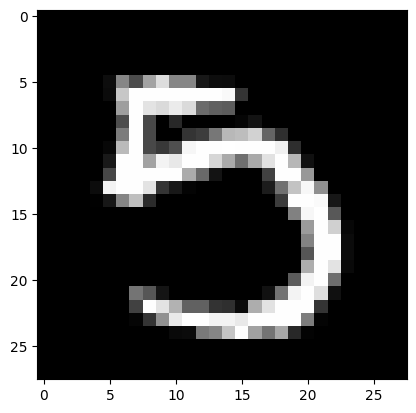

In [14]:
theta = torch.load("plotting_code/plotting_data/data_x_test.pt")
print(theta.shape)

sim = simulator(theta)

print(sim.shape)
plt.imshow(theta[0][0], cmap="gray")
plt.show()


In [13]:
from glob import glob

n_post_samples = 1
df_in = runs_list

scoring_rule_list = ["energy_score"]
patches_list = [[5,8]]

my_names_list = []

for scoring_rule in scoring_rule_list:
    for patch in patches_list:

        # obtain the identifier
        df = df_in[df_in.scoring_rule == scoring_rule]
        if patch is None: 
            df = df[df.patched_sr == False]
        else:
            df = df[df.patched_sr== True]
            df = df[df.patch_size == patch[1]]         
            
        identifier = df["ID"].item()
        print(identifier)

        # obtain the path
        correct_folder = glob(root_folder + f"/wandb/*{identifier}*")
        if len(correct_folder) == 0:
            print("No match")
            continue
        correct_folder = correct_folder[0]
        
        # now should load the generative network for that folder:        
        chpt = torch.load(correct_folder +  "/files/checkpoint_models0.pt",map_location=torch.device('cpu') )
        gen.load_state_dict(chpt["generator_state_dict"])

        # wrap the generator so that it can generate multiple samples at once: 
        gen_wrapped = WrapGenMultipleSimulations(gen, n_simulations=n_post_samples)        
        
        name = scoring_rule + ("" if patch is None else (str(patch[0]) + "_" + str(patch[1])))
        my_names_list.append(name)
        
        # now feed the observations into the generator to obtain posterior samples: 
        # samples_list.append(gen_wrapped(obs_test_tensor).squeeze().detach().numpy() + 10)  # translate up by 10
        posterior = torch.stack([gen_wrapped(sim[i].unsqueeze(0)) for i in range(1000)])
        print(posterior.shape)  # translate up by 10
        post_df = posterior.squeeze()
        #post_df = torch.mean(posterior.squeeze(), dim = 1)
        #post_df = torch.var(posterior.squeeze(), dim = 1)
        print(post_df.shape)
        # now pass through the simulator to obtain posterior predictive samples: should not do any fourier transform either
        # simulations_list.append(np.array([simulator(sample.reshape(1,-1))[0] for sample in samples_list[-1]]).squeeze())
        #z_samples[name] = np.array([simulator(sample.reshape(1,-1))[0] for sample in post_samples[name]]).squeeze()
        
        #break
    #break

 

lsxg4l69
torch.Size([1000, 1, 1, 1, 28, 28])
torch.Size([1000, 28, 28])


In [9]:
import os
import torch
import torchvision.utils as vutils


def save_image(tensor, fp, format=None, **kwargs):
    normalized = normalize_tensor(tensor)
    vutils.save_image(normalized, fp, format=format, **kwargs)

def normalize_tensor(tensor):
    normalized = tensor / 2 + 0.5
    return normalized.clamp_(0, 1)

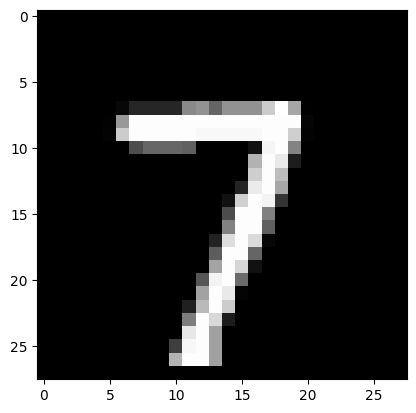

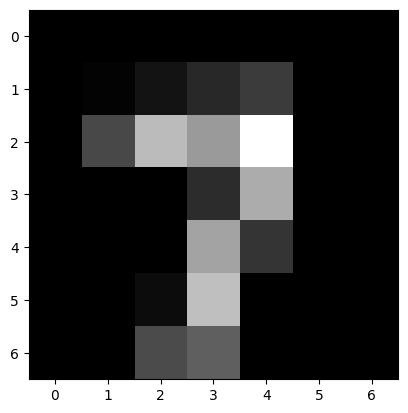

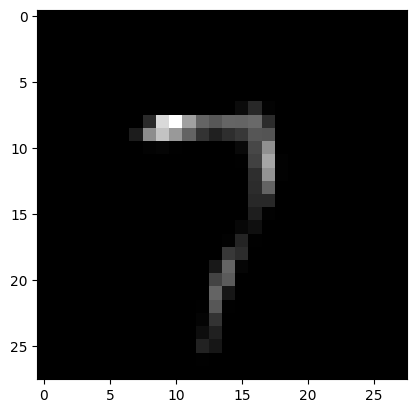

In [17]:
count = 6

plt.imshow(theta[count][0], cmap="gray")

plt.show()
plt.imshow(sim[count][0], cmap="gray")
plt.show()
plt.imshow(post_df.detach().numpy()[count], cmap="gray")
plt.show()


In [11]:

psnr = PeakSignalNoiseRatio()
ssim = StructuralSimilarityIndexMeasure()
vals_psnr = []
vals_ssim = []
for i in range(1000):
    vals_psnr.append(psnr(post_df[i],theta[i][0]).detach().numpy())
print("PSNR: ",np.mean(vals_psnr))
print("SSIM: ",ssim(post_df.unsqueeze(1),theta[:1000]).detach().numpy())




PSNR:  6.467218
SSIM:  0.020402847
